# Project for IT1244 **(Fraud in Electricity and Gas Consumption Dataset)**

## Importing dataset, libraries and reading files

In [46]:
# import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import auc


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

Read in the data

In [5]:
# Read the CSV file
# client_data = pd.read_csv(io.BytesIO(uploaded['client.csv']))
# invoice_data = pd.read_csv(io.BytesIO(uploaded['invoice.csv']))
client_data = pd.read_csv("client.csv")
invoice_data = pd.read_csv("invoice.csv")

##Explore Data

In [6]:
# Number of unique ids in client_data and invoice_data
unique_ids_in_client_data = client_data.id.unique()
unique_ids_in_invoice_data = invoice_data.id.unique()
print(f"Number of unique id in client_data : {len(unique_ids_in_client_data)}")
print(f"Number of unique id in invoice_data : {len(unique_ids_in_invoice_data)}")

Number of unique id in client_data : 135493
Number of unique id in invoice_data : 31603


Notice that we have **135493 clients** in `client_data` but only **31603 (~ 23%)** of them are in `invoice_data`.

We will discard clients which we do not have invoice data.

This is because the goal of the model is to predict fraudulent manipulations of meters through customer's **consumption behaviour**.

However, without any invoice data, we are not able to observe their consumption behavior.

We create `client_data_with_invoice`, which are clients which we have invoice data.

These clients are from `train_Client_0` to `train_Client_128439`, there are **31603** such clients.

In [7]:
# We now only consider clients who have invoice data
unique_ids_in_invoice_data = invoice_data.id.unique()
clients_with_invoice = client_data[client_data['id'].isin(unique_ids_in_invoice_data)]

In [8]:
# Get invoice_data of each unique client
invoice_data_grouped_by_id = invoice_data.groupby('id')
invoice_data_grouped_by_id.get_group("train_Client_0")
for idx, col in enumerate(invoice_data.columns):
    print(idx, col)

0 id
1 date
2 tarif_type
3 counter_number
4 counter_statue
5 counter_code
6 reading_remarque
7 consommation_level_4
8 old_index
9 new_index
10 months_number
11 counter_type
12 counter_coefficient
13 consommation_level_1
14 consommation_level_2
15 consommation_level_3


In [9]:
# Create New DataFrame containing summary statistics of every client.
invoice_summary = {'id': [], # Client's id
                   ### ELEC
                   # Tarif Type
                   'elec_mode_tarif_type': [], # Mode of tarif_type
                   # Counter Statue
                   'elec_mode_counter_statue': [], # Mode of counter statue
                   # Months Number
                   'elec_mode_months_number': [], # Mode of months number
                   # Counter Coefficient
                   'elec_mode_counter_coefficient': [], # Mode of counter coefficient
                   # Number of Invoices
                   'elec_number_of_invoices': [], # Number of invoices
                   # Reading Remarque
                   'elec_avg_reading_remarque': [], # Average
                   'elec_sd_reading_remarque': [], # Standard Deviation
                   # Consommation Level 1
                   'elec_avg_con_1': [], # Average
                   'elec_sd_con_1': [], # Standard Deviation
                    # Consommation Level 2
                   'elec_avg_con_2': [], # Average
                   'elec_sd_con_2': [], # Standard Deviation
                    # Consommation Level 3
                   'elec_avg_con_3': [], # Average
                   'elec_sd_con_3': [], # Standard Deviation
                    # Consommation Level 4
                   'elec_avg_con_4': [], # Average
                   'elec_sd_con_4': [], # Standard Deviation

                   ### GAZ
                   # Tarif Type
                   'gaz_mode_tarif_type': [], # Mode of tarif_type
                   # Counter Statue
                   'gaz_mode_counter_statue': [], # Mode of counter statue
                   # Months Number
                   'gaz_mode_months_number': [], # Mode of months number
                   # Counter Coefficient
                   'gaz_mode_counter_coefficient': [], # Mode of counter coefficient
                   # Number of Invoices
                   'gaz_number_of_invoices': [], # Number of invoices
                   # Reading Remarque
                   'gaz_avg_reading_remarque': [], # Average
                   'gaz_sd_reading_remarque': [], # Standard Deviation
                   # Consommation Level 1
                   'gaz_avg_con_1': [], # Average
                   'gaz_sd_con_1': [], # Standard Deviation
                    # Consommation Level 2
                   'gaz_avg_con_2': [], # Average
                   'gaz_sd_con_2': [], # Standard Deviation
                    # Consommation Level 3
                   'gaz_avg_con_3': [], # Average
                   'gaz_sd_con_3': [], # Standard Deviation
                    # Consommation Level 4
                   'gaz_avg_con_4': [], # Average
                   'gaz_sd_con_4': [], # Standard Deviation
                   }

invoice_summary_dataFrame = pd.DataFrame(invoice_summary)

invoice_summary_dataFrame = invoice_summary_dataFrame.astype(float)

invoice_summary_dataFrame



,id,elec_mode_tarif_type,elec_mode_counter_statue,elec_mode_months_number,elec_mode_counter_coefficient,elec_number_of_invoices,elec_avg_reading_remarque,elec_sd_reading_remarque,elec_avg_con_1,elec_sd_con_1,...,gaz_avg_reading_remarque,gaz_sd_reading_remarque,gaz_avg_con_1,gaz_sd_con_1,gaz_avg_con_2,gaz_sd_con_2,gaz_avg_con_3,gaz_sd_con_3,gaz_avg_con_4,gaz_sd_con_4


In [10]:
# Calculate Summary Statistics
def summary_statistics(dataFrame):
    if len(dataFrame) == 0:
        return [-1,-1]
    if len(dataFrame) == 1: # Cannot calculate std if we only have one data point.
        std = -1
    else:
        std = dataFrame.std()
    return [dataFrame.mean(), std]

# Find Mode
def find_mode(dataFrame):
    if len(dataFrame) == 0:
        return -1
    else:
        return dataFrame.mode()[0]

# Dropped counter_number, counter_code
def process_client_invoice_data(client_id):
    data = []
    data.append(client_id)
    client_invoice = invoice_data_grouped_by_id.get_group(client_id)
    client_invoice_type = client_invoice.groupby('counter_type')

    if 'ELEC' in client_invoice_type.groups:
        elec_client_invoice = client_invoice_type.get_group('ELEC')
    else:
        elec_client_invoice = []

    if 'GAZ' in client_invoice_type.groups:
        gaz_client_invoice = client_invoice_type.get_group('GAZ')
    else:
        gaz_client_invoice = []

    for invoice in [elec_client_invoice, gaz_client_invoice]:
        # Categorical Data: tarif_type, counter_statue, counter_code
        for cat_data in [2, 4, 10, 12]:
            if len(invoice) == 0:
                to_check = []
            else:
                to_check = invoice.iloc[: , cat_data]
            data.append(find_mode(to_check))
        # Number of Invoices
        data.append(len(invoice))
        # Numerical Data
        for num_data in [6, 13, 14, 15, 7]:
            if len(invoice) == 0:
                to_check = []
            else:
                to_check = invoice.iloc[: , num_data]
            data.extend(summary_statistics(to_check))

    return data

pos = 0
for id in unique_ids_in_invoice_data:
    invoice_summary_dataFrame.loc[pos] = process_client_invoice_data(id)
    pos += 1

In [11]:
invoice_summary_dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31603 entries, 0 to 31602
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             31603 non-null  object 
 1   elec_mode_tarif_type           31603 non-null  int64  
 2   elec_mode_counter_statue       31603 non-null  int64  
 3   elec_mode_months_number        31603 non-null  int64  
 4   elec_mode_counter_coefficient  31603 non-null  int64  
 5   elec_number_of_invoices        31603 non-null  int64  
 6   elec_avg_reading_remarque      31603 non-null  float64
 7   elec_sd_reading_remarque       31603 non-null  float64
 8   elec_avg_con_1                 31603 non-null  float64
 9   elec_sd_con_1                  31603 non-null  float64
 10  elec_avg_con_2                 31603 non-null  float64
 11  elec_sd_con_2                  31603 non-null  float64
 12  elec_avg_con_3                 31603 non-null 

In [12]:
invoice_summary_dataFrame.describe(include="all")

,id,elec_mode_tarif_type,elec_mode_counter_statue,elec_mode_months_number,elec_mode_counter_coefficient,elec_number_of_invoices,elec_avg_reading_remarque,elec_sd_reading_remarque,elec_avg_con_1,elec_sd_con_1,...,gaz_avg_reading_remarque,gaz_sd_reading_remarque,gaz_avg_con_1,gaz_sd_con_1,gaz_avg_con_2,gaz_sd_con_2,gaz_avg_con_3,gaz_sd_con_3,gaz_avg_con_4,gaz_sd_con_4
count,31603,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,...,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000,31603.000000
unique,31603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,train_Client_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10.869474,0.012341,11.584691,0.992532,22.814733,7.397513,0.923902,504.957984,303.745243,...,2.793496,-0.132568,84.113915,77.978798,0.037007,-0.129864,-0.540803,-0.552606,-0.540803,-0.552606
std,NaN,1.002885,0.233647,910.795813,0.327245,16.552420,1.058491,0.650104,750.326956,561.450542,...,4.161384,1.016660,231.247505,256.199634,53.090950,35.874832,0.498340,0.497233,0.498340,0.497233
min,NaN,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,NaN,11.000000,0.000000,4.000000,1.000000,9.000000,6.843750,0.612372,263.091724,146.192959,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,NaN,11.000000,0.000000,4.000000,1.000000,23.000000,7.333333,1.200490,442.357143,253.504675,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,NaN,11.000000,0.000000,4.000000,1.000000,35.000000,8.000000,1.366655,659.000000,378.918023,...,7.033333,1.035032,96.215839,61.645037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# Join client_with_invoice with invoice_summary_dataFrame on 'id'
df = pd.merge(clients_with_invoice, invoice_summary_dataFrame, on='id', how='inner')
# Drop id, as it has nothing to do with fraud or not.
df = df.drop('id', axis=1)
# We consider the year the client joined, instead of the date
df['date'] = pd.to_datetime(df['date'], dayfirst=True).apply(lambda datetime: datetime.year)
df.rename(columns={'date':'year'}, inplace=True)

We might be curious whether the summary statistics calculated are effective in differentiating fraud clients from the non-fraud ones.
The visualization below suggests that they are.

For example, we see that the standard deviation of Consumption Level 1 differentiates the non-fraud clients (blue) from the fraud-clients (red).
- Notice that there is a concentration of non-fraud clients around 0.
- Notice that there is a concentration of fraud clients around 300.

Since there are way too many non-fraud clients compared to fraud clients, we create a sample of 3000 clients, half non-fraud, half fraud, so that we can use the visualization techniques effectively.

(Otherwise we would not be able to observe the pattern of fraud clients since they will be overpowered by non-fraud clients).

Number of clients with `elec_sd_con_1` > 1000: 541.
Number of non-fraud clients with `elec_sd_con_1` > 1000: 499.
Number of fraud clients with `elec_sd_con_1` > 1000: 42.
Number of fraud clients: 1757
Note that out of 1757 fraud clients, there are only 42 with standard deviation 1000 and above, they are negligible.


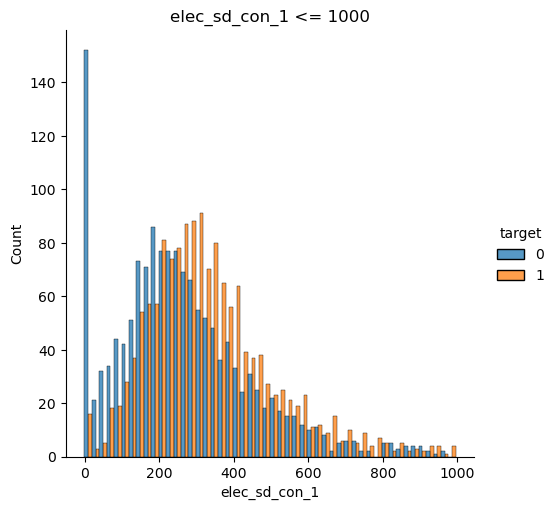

In [14]:
# We group the clients in df by whether they are fraud or not
df_grouped_by_target = df.groupby('target')

# Now we randomly sample 1500 non-fraud clients with `elec_sd_con_1` <= 1000
fraud = df_grouped_by_target.get_group(0)
sample_fraud_below_200 = fraud[fraud['elec_sd_con_1'] <= 1000].sample(n=1500)

# And also sample 1500 fraud-clients with `elec_sd_con_1` <= 1000
not_fraud = df_grouped_by_target.get_group(1)
sample_not_fraud_below_200 = not_fraud[not_fraud['elec_sd_con_1'] <= 1000].sample(n=1500)

# We now have a sample consisting of 3000 clients
sample_below_200 = pd.concat([sample_fraud_below_200, sample_not_fraud_below_200], axis=0)

# We observe the distribution of their standard deviation
sns.displot(sample_below_200, x="elec_sd_con_1", bins = 50, hue="target",  multiple='dodge').set(title="elec_sd_con_1 <= 1000")

# Number of clients with `elec_sd_con_1` > 1000
print(f"Number of clients with `elec_sd_con_1` > 1000: {len(df[df['elec_sd_con_1'] > 1000])}.")
print(f"Number of non-fraud clients with `elec_sd_con_1` > 1000: {len(df[(df['elec_sd_con_1'] >= 1000) & (df['target'] == 0)])}.")
print(f"Number of fraud clients with `elec_sd_con_1` > 1000: {len(df[(df['elec_sd_con_1'] >= 1000) & (df['target'] == 1)])}.")
print(f"Number of fraud clients: {len(df[df['target'] == 1])}")
print("Note that out of 1757 fraud clients, there are only 42 with standard deviation 1000 and above, they are negligible.")

# Machine Learning Algorithms for Classification

## Logistic Regression on Invoices, without feature selection

To get a baseline of how our logistic regression model performs, lets try to simply join the client dataset with their invoices (considering only clients that have invoices) and run a logistic regression model on all invoices  

In [15]:
# join dataframe with clients_with_invoice and invoice_data
naive_df = pd.merge(clients_with_invoice, invoice_data, on='id', how='inner')
# clean up dataframe, convert counter_type to float (0 for elec, 1 for gas)
naive_df['counter_type'] = naive_df['counter_type'].apply(lambda x: 0 if x == 'ELEC' else 1)
# format date column
naive_df['date_x'] = pd.to_datetime(naive_df['date_x'])
naive_df['date_y'] = pd.to_datetime(naive_df['date_y'])
naive_df['date_x'] = naive_df['date_x'].apply(lambda x: x.timestamp())
naive_df['date_y'] = naive_df['date_y'].apply(lambda x: x.timestamp())
# convert client id from string to float
naive_df['id'] = naive_df['id'].apply(lambda x: int(x.split('_')[-1]))


/var/folders/97/dwh90kfn0db3d8d2fwwh_6x80000gn/T/ipykernel_74097/3193368480.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  naive_df['date_x'] = pd.to_datetime(naive_df['date_x'])
/var/folders/97/dwh90kfn0db3d8d2fwwh_6x80000gn/T/ipykernel_74097/3193368480.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  naive_df['date_y'] = pd.to_datetime(naive_df['date_y'])


Let us evaluate the performance of this logistic regression model.

We can do so by calculating the **confusion matrix** and other key statistics

We can also plot the **ROC curve**.

**Note that in this context a "positive" result refers to a fradulent client**

In [50]:
def measure_logreg_performance(df):
    # Split data into training and testing data for logistic regression
    X = df.drop('target', axis=1)
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    # run logistic regression and fit model from sklearn
    logreg = LogisticRegression(random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    # plot confusion matrix for logistic regression model
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(f"True Positives (TP): {cm[1,1]}")
    print(f"True Negatives (TN): {cm[0,0]}")
    print(f"False Positives (FP): {cm[0,1]}")
    print(f"False Negatives (FN): {cm[1,0]}")

    # calculate accuracy, precision, recall, f1-score
    print(classification_report(y_test, y_pred))

    # plot ROC curve
    # reference: https://www.datacamp.com/tutorial/understanding-logistic-regression-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=143216588577&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=676354849139&utm_targetid=dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=9062542&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na-oct23&gclid=CjwKCAjwkNOpBhBEEiwAb3MvvXmfFm-Z9yFqOBbjBwFAFkTwoiEIQYPwuljT1MA_AWrKt_lB3QUrRBoCfisQAvD_BwE
    y_pred_proba = logreg.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(loc=4)
    plt.show()

Confusion Matrix:
True Positives (TP): 0
True Negatives (TN): 193740
False Positives (FP): 0
False Negatives (FN): 15975
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    193740
           1       0.00      0.00      0.00     15975

    accuracy                           0.92    209715
   macro avg       0.46      0.50      0.48    209715
weighted avg       0.85      0.92      0.89    209715



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

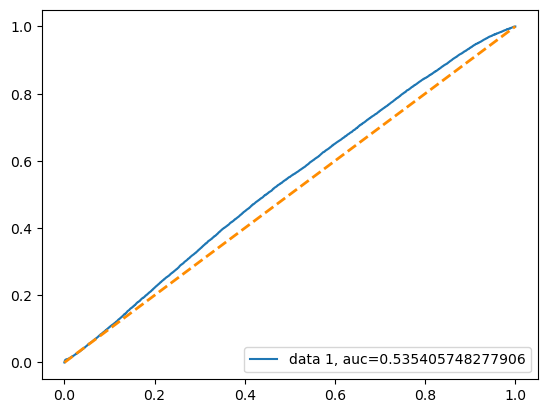

In [51]:
measure_logreg_performance(naive_df)

From the results, the accuracy of the model (0.92) seems high, however, by looking at the confusion matrix, we realise that the both the true and false positive rate is 0%. This means the model simply predicts false (non-fraud) for all invoices. Therefore, the model is not useful, although accuracy seems high.

Another metric we used is the area under the ROC curve. Here we see that the area under the ROC curve is 0.535. This is close to 0.5, which indicates that the model makes seemingly random predictions. Therefore, we need to perform some feature selection, feature scaling or resampling

*The below code takes approximately 1 hour to run.*

Uncomment to run. It selects the 10 "best" features. However, we determined that these features were not beneficial to our study.

In [18]:
'''
# look at columns of df
naive_df.columns
# drop dates since they are hard to pass into RFE, and don't seem significant
new_df = naive_df.drop(['date_x', 'date_y'], axis=1)
X = new_df.drop('target', axis=1)
y = new_df['target']
# format categorical variables, using one-hot encoding
categorical_feats = ['region', 'dis', 'catg', 'tarif_type']
categorical_features_encoded = pd.get_dummies(new_df, columns=categorical_feats)
# Concatenate one-hot encoded categorical features with numerical features
numerical_features = X.drop(categorical_feats, axis=1)
X = pd.concat([categorical_features_encoded, numerical_features], axis=1)

# Create a classifier for RFE
classifier = RandomForestClassifier()
# Create an instance of RFE
rfe = RFE(classifier, n_features_to_select=10)
# Fit the RFE selector to your data
X_new = rfe.fit_transform(X, y)
# Get the indices of the selected features
selected_features_indices = rfe.support_
# Use the selected features for further analysis
selected_features = X.columns[selected_features_indices]
'''

"\n# look at columns of df\nnaive_df.columns\n# drop dates since they are hard to pass into RFE, and don't seem significant\nnew_df = naive_df.drop(['date_x', 'date_y'], axis=1)\nX = new_df.drop('target', axis=1)\ny = new_df['target']\n# format categorical variables, using one-hot encoding\ncategorical_feats = ['region', 'dis', 'catg', 'tarif_type']\ncategorical_features_encoded = pd.get_dummies(new_df, columns=categorical_feats)\n# Concatenate one-hot encoded categorical features with numerical features\nnumerical_features = X.drop(categorical_feats, axis=1)\nX = pd.concat([categorical_features_encoded, numerical_features], axis=1)\n\n# Create a classifier for RFE\nclassifier = RandomForestClassifier()\n# Create an instance of RFE\nrfe = RFE(classifier, n_features_to_select=10)\n# Fit the RFE selector to your data\nX_new = rfe.fit_transform(X, y)\n# Get the indices of the selected features\nselected_features_indices = rfe.support_\n# Use the selected features for further analysis\nsel

These were the 10 most important features: 'id', 'target', 'counter_number', 'region_101', 'region_103', 'catg_51', 'counter_number', 'counter_code', 'months_number'

In [19]:
# print(selected_features)

## Logistic Regression
Now, we try to implement **logistic regression** on the clients, without any feature scaling or **resampling**

Confusion Matrix:
True Positives (TP): 0
True Negatives (TN): 5951
False Positives (FP): 1
False Negatives (FN): 369
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5952
           1       0.00      0.00      0.00       369

    accuracy                           0.94      6321
   macro avg       0.47      0.50      0.48      6321
weighted avg       0.89      0.94      0.91      6321



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


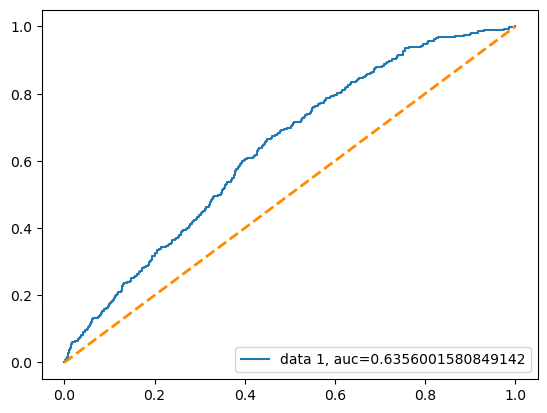

In [52]:
measure_logreg_performance(df)

Let us evaluate the performance of this logistic regression model.

We can do so by calculating the **confusion matrix** and other key statistics

We can also plot the **ROC curve**.

**Note that in this context a "positive" result refers to a fradulent client**

From the results, it seems that the logistic regression model is good, since it has a high accuracy (0.94)

However, since the data is highly imbalanced (very low number of fraud/positive cases), this model may not be useful.

The model had a precision of 0.14 in predicting fraud. This means that the model is not useful in accurately predicting any fradulent cases.

Therefore, this logistic regression model may not be very useful if we do not perform any feature scaling or resampling

## Logistic Regression with resampling

### Undersampling

Here, we handle imbalanced data by only taking a sample of the majority class that has the same size as the minority class, giving us a balanced dataset with the size of 2n, where n is the size of the minority class.

Confusion Matrix:
True Positives (TP): 246
True Negatives (TN): 203
False Positives (FP): 165
False Negatives (FN): 89
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       368
           1       0.60      0.73      0.66       335

    accuracy                           0.64       703
   macro avg       0.65      0.64      0.64       703
weighted avg       0.65      0.64      0.64       703



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


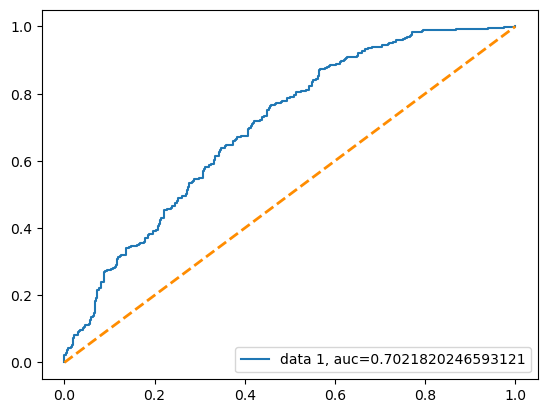

In [53]:
def random_undersampling(df: pd.DataFrame) -> pd.DataFrame:
    min = df['target'].value_counts().min()
    legit_df = df[df['target'] == 0].sample(n=min)
    fraud_df = df[df['target'] == 1].sample(n=min)
    return pd.concat([legit_df, fraud_df])

# Undersample the data
df_undersampled = random_undersampling(df)

# Measure performance
measure_logreg_performance(df_undersampled)

### Oversampling

Here, we handle imbalanced data by only taking a sample of the minority class with duplicates such that it matches the size of the majority class. This gives us a balanced dataset of size 2m, where m is the size of the majority class.

Confusion Matrix:
True Positives (TP): 4229
True Negatives (TN): 3006
False Positives (FP): 2970
False Negatives (FN): 1734
              precision    recall  f1-score   support

           0       0.63      0.50      0.56      5976
           1       0.59      0.71      0.64      5963

    accuracy                           0.61     11939
   macro avg       0.61      0.61      0.60     11939
weighted avg       0.61      0.61      0.60     11939



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


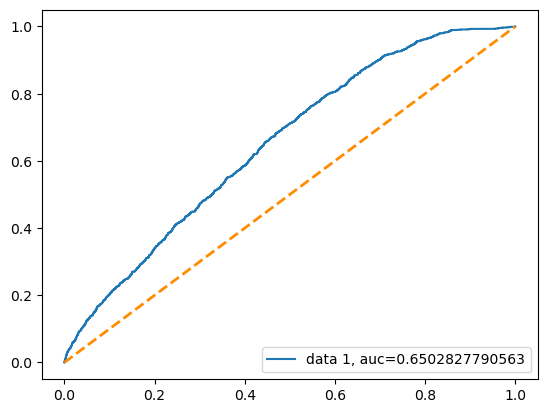

In [92]:
def random_oversampling(df: pd.DataFrame) -> pd.DataFrame:
    max = df['target'].value_counts().max()
    legit_df = df[df['target'] == 0].sample(n=max, replace=True)
    fraud_df = df[df['target'] == 1].sample(n=max, replace=True)
    return pd.concat([legit_df, fraud_df])

# Oversample the data
df_oversampled = random_oversampling(df)

# Measure performance
measure_logreg_performance(df_oversampled)

## Logistic Regression with feature scaling

Observing the dataset, we observe that there

Numerical features: year, months, counter_coefficient, number_of_invoices, con_1, con_2, con_3, con_4,

Nominal features: region, dis, catg, tarif_type, counter_statue

Ordinal features: reading_remarque



In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31603 entries, 0 to 31602
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   region                         31603 non-null  int64  
 1   year                           31603 non-null  int64  
 2   dis                            31603 non-null  int64  
 3   catg                           31603 non-null  int64  
 4   target                         31603 non-null  int64  
 5   elec_mode_tarif_type           31603 non-null  int64  
 6   elec_mode_counter_statue       31603 non-null  int64  
 7   elec_mode_months_number        31603 non-null  int64  
 8   elec_mode_counter_coefficient  31603 non-null  int64  
 9   elec_number_of_invoices        31603 non-null  int64  
 10  elec_avg_reading_remarque      31603 non-null  float64
 11  elec_sd_reading_remarque       31603 non-null  float64
 12  elec_avg_con_1                 31603 non-null 

Since the magnitude of these features differ quite greatly, the logistic regression model may be biased to certain features.

Therefore, we perform feature scaling to improve the convergence of our logistic regression model.

First, we use methods such as standardization/normalization to scale the numerical features

In [70]:
scaled_df = df
# perform feature scaling using standardization
s_scaler = MinMaxScaler()

# we want to scale numerical features: year, month, counter_coefficient, number_of_invoices, con_1, con_2, con_3, con_4
numerical_features_idxs = [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                           22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
# grab the subset of numerical features to be scaled and standardise it
std_subset = scaled_df.iloc[:, numerical_features_idxs]
standardized_data = pd.DataFrame(s_scaler.fit_transform(std_subset), columns=std_subset.columns)
scaled_df.iloc[:, numerical_features_idxs] = standardized_data

# we perform one-hot encoding on categorical features: region, dis, catg, tarif_type
categorical_feats = ['region', 'dis', 'catg', 'elec_mode_tarif_type', 'elec_mode_counter_statue', 'gaz_mode_tarif_type', 'gaz_mode_counter_statue']
categorical_features_encoded = pd.get_dummies(scaled_df, columns=categorical_feats)
# Concatenate one-hot encoded categorical features with numerical features
numerical_features = scaled_df.drop(categorical_feats + ["target"], axis=1)
scaled_df = pd.concat([categorical_features_encoded, numerical_features], axis=1)

Perform logistic regression with this data

In [71]:
scaled_df.head()


,year,target,elec_mode_months_number,elec_mode_counter_coefficient,elec_number_of_invoices,elec_avg_reading_remarque,elec_sd_reading_remarque,elec_avg_con_1,elec_sd_con_1,elec_avg_con_2,...,gaz_avg_reading_remarque,gaz_sd_reading_remarque,gaz_avg_con_1,gaz_sd_con_1,gaz_avg_con_2,gaz_sd_con_2,gaz_avg_con_3,gaz_sd_con_3,gaz_avg_con_4,gaz_sd_con_4
0,0.404762,0,0.000033,0.039216,0.079727,0.797143,0.720270,0.006694,0.006313,0.000297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.595238,0,0.000033,0.039216,0.084282,0.821622,0.761568,0.010580,0.004034,0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.214286,0,0.000033,0.039216,0.041002,0.805556,0.723718,0.015147,0.010439,0.000997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.452381,0,0.000033,0.039216,0.045558,0.715000,0.535293,0.000042,0.000093,0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.880952,0,0.000033,0.039216,0.031891,0.985714,0.436718,0.012591,0.004579,0.002714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Confusion Matrix:
True Positives (TP): 0
True Negatives (TN): 5951
False Positives (FP): 1
False Negatives (FN): 369
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5952
           1       0.00      0.00      0.00       369

    accuracy                           0.94      6321
   macro avg       0.47      0.50      0.48      6321
weighted avg       0.89      0.94      0.91      6321



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


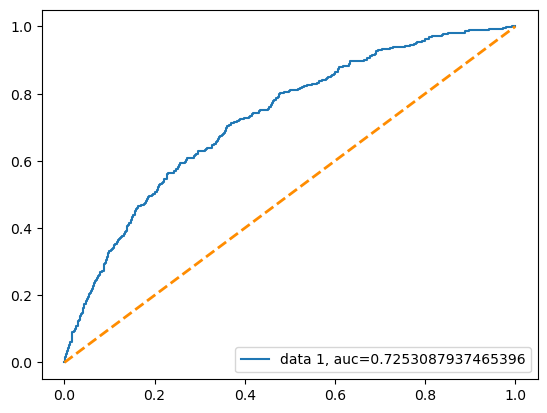

In [73]:
measure_logreg_performance(scaled_df)

Here we see that with feature scaling and one-hot encoding of categorical variables, the performance of the logistic regression model improved slightly. The area under the ROC curve increase from 0.698 (without resampling) to 0.725.

## Logistic Regression with resampling and feature scaling

Since we concluded that feature scaling is useful in increasing the performance of our model, and resamplin makes the results of our model less biased, we try to implement both resampling and feature scaling

In [27]:
# Feature Scaling + Undersampling
scaled_df_us = random_undersampling(scaled_df)

# Feature Scaling + Oversampling
scaled_df_os = random_oversampling(scaled_df)

Lets compare the performance of the model using resampling and feature scaling

Confusion Matrix:
True Positives (TP): 236
True Negatives (TN): 223
False Positives (FP): 145
False Negatives (FN): 99
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       368
           1       0.62      0.70      0.66       335

    accuracy                           0.65       703
   macro avg       0.66      0.66      0.65       703
weighted avg       0.66      0.65      0.65       703



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


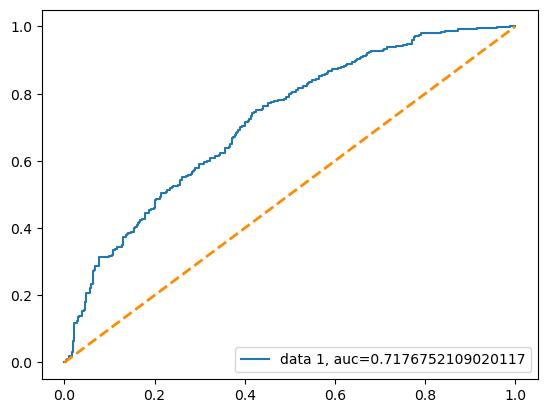

Confusion Matrix:
True Positives (TP): 4145
True Negatives (TN): 3821
False Positives (FP): 2155
False Negatives (FN): 1818
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      5976
           1       0.66      0.70      0.68      5963

    accuracy                           0.67     11939
   macro avg       0.67      0.67      0.67     11939
weighted avg       0.67      0.67      0.67     11939



/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


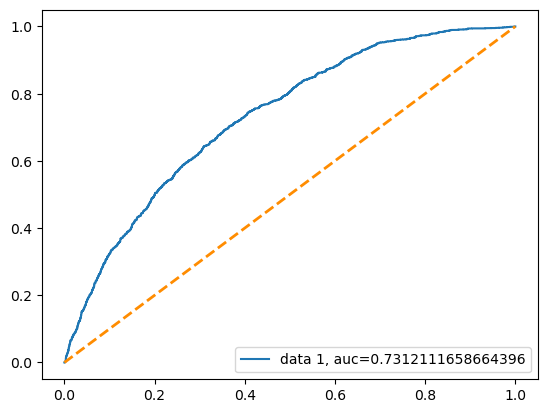

In [78]:
measure_logreg_performance(scaled_df_us)
measure_logreg_performance(scaled_df_os)

From the results, we can see that the accuracy of the model using feature scaling and undersampling is 0.68, and AUC is 0.755, while the accuracy of the model using feature scaling and oversampling is 0.66 and AUC is 0.731.

The area under the ROC curve is 0.731, which shows that our model has a 73.1% chance to distinguish between a fraud and non-fraud client. Therefore, this model is useful.

## K-Nearest Neighbors (KNN)

Nominal features: region, dis, catg, tarif_type, counter_statue
Next, we perform KNN on the dataset, with the scaled data.

In [47]:
X1 = scaled_df.drop('target', axis=1)
y1 = scaled_df['target']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=101)

knn = KNeighborsClassifier(n_neighbors = int(math.sqrt(len(X1))))
knn.fit(X1_train, y1_train)
pred = knn.predict(X1_test)

conf_matrix = confusion_matrix(y1_test, pred)
label = ['not fraud', 'fraud']


print('Confusion Matrix [[TN FP] [FN TP]]:', conf_matrix)

# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

print(TN, FP, FN, TP )

accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'accuracy = {accuracy}')


# Precision
precision = TP / (TP + FP)
print(f'precision = {precision}')

# True Positive Rate (Sensitivity or Recall)
recall = TP / (TP + FN)
print(f'recall = {recall}')

# False Positive Rate
fpr = FP / (FP + TN)
print(f'FPR = {fpr}')


#positive means fraud

#measure_performance(y1_test, pred)
#print(len(X_test))
#print(len(X_train))

#print(len(scaled_df))

Confusion Matrix [[TN FP] [FN TP]]: [[5952    0]
 [ 369    0]]
5952 0 369 0
accuracy = 0.9416231608922638
precision = nan
recall = 0.0
FPR = 0.0


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/var/folders/97/dwh90kfn0db3d8d2fwwh_6x80000gn/T/ipykernel_74097/1862949972.py:25: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


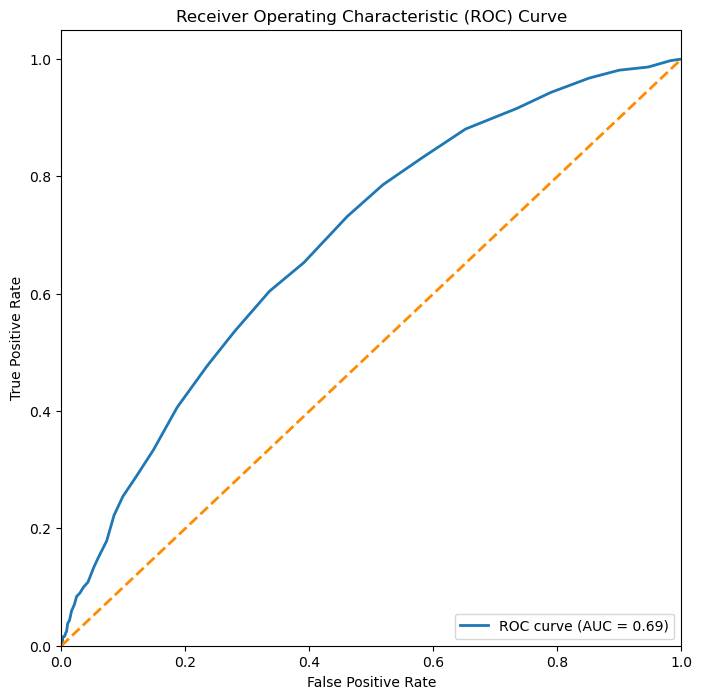

In [49]:
y1_prob = knn.predict_proba(X1_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y1_test, y1_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



Once again, KNN returned a high accuracy of 0.94 similary, it uncertained that this model was useful be useful because of the highly imbalanced dataset and low number of fraud cases.  


Cross validation

In [38]:
k_values = [1, 3, 5, 7, 9]

recall_scorer = make_scorer(recall_score, pos_label=1)

# Iterate through different k values
for k in k_values:
    # Create a KNN classifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform 10-fold cross-validation with TPR as the scoring metric
    cross_val_results = cross_val_score(knn, X1, y1, cv=10, scoring=recall_scorer)

    # Print the average TPR for the current k value
    print(f'Average TPR for k={k}: {np.mean(cross_val_results)}')

/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

Average TPR for k=1: 0.10016883116883117


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

Average TPR for k=3: 0.03585064935064935


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

Average TPR for k=5: 0.018779220779220777


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

Average TPR for k=7: 0.014805194805194804


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimi

Average TPR for k=9: 0.006262987012987014


/Users/edricyeo/anaconda3/envs/cs2109s-ay2223s1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Weighted KNN

In [41]:
# Assuming you have X1 and y1 from your code
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=101)

# Calculate class weights for imbalanced dataset
sample_weights = compute_sample_weight(class_weight='balanced', y=y1_train)

# Create a KNN classifier with weighted voting
knn2 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn2.fit(X1_train, y1_train)
pred = knn2.predict(X1_test)

conf_matrix = confusion_matrix(y1_test, pred)
label = ['not fraud', 'fraud']


print('Confusion Matrix [[TN FP] [FN TP]]:', conf_matrix)

# Extract values from the confusion matrix
TN_2, FP_2, FN_2, TP_2 = conf_matrix.ravel()

accuracy_2 = (TP_2 + TN_2) / (TP_2 + TN_2 + FP_2 + FN_2)
print(f'accuracy = {accuracy_2}')

# Precision
precision_2 = TP_2 / (TP_2 + FP_2)
print(f'precision = {precision_2}')

# True Positive Rate (Sensitivity or Recall)
recall_2 = TP_2 / (TP_2 + FN_2)
print(f'recall = {recall_2}')

# False Positive Rate
fpr_2 = FP_2 / (FP_2 + TN_2)
print(f'FPR = {fpr_2}')


Confusion Matrix [[TN FP] [FN TP]]: [[5861   91]
 [ 355   14]]
accuracy = 0.9294415440594842
precision = 0.13333333333333333
recall = 0.037940379403794036
FPR = 0.015288978494623656


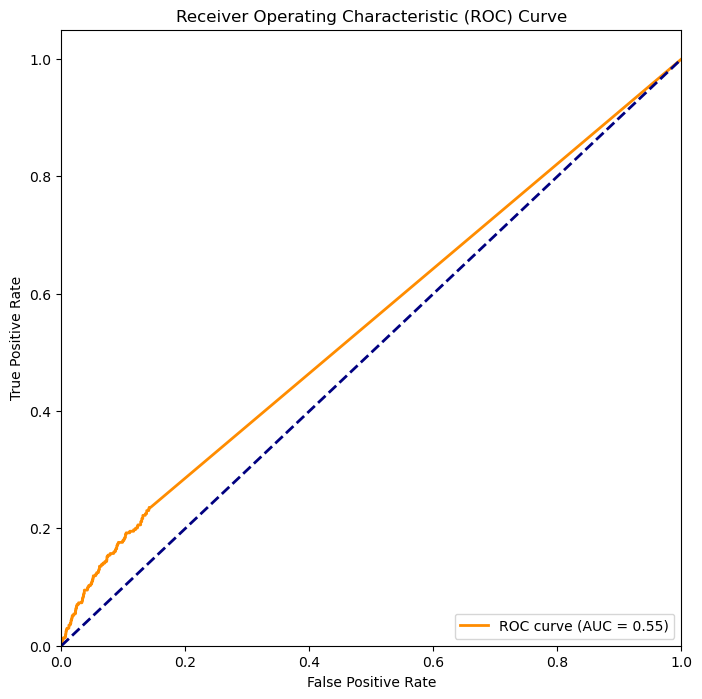

In [33]:
y1_prob = knn2.predict_proba(X1_test)[:, 1]

# Compute ROC curve and ROC area
fpr_2, tpr_2, thresholds = roc_curve(y1_test, y1_prob)
roc_auc = auc(fpr_2, tpr_2)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_2, tpr_2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

XGBoost

In [44]:
# Separate target variable
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the XGBClassifier 
model = XGBClassifier(objective='binary:logistic')

X_train_not_fraud = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]
# Each time the training set will have the same number of non-fraud and fraud-clients
len_split = len(X_train_fraud)


for training_round in range(17):
    normal_idx = pd.DataFrame({'normal_idx':range(2 * len_split)})
    # We randomize the order of the data
    random_idx = np.random.permutation(normal_idx.index)
    X_train_split = pd.concat( [X_train_fraud, X_train_not_fraud[training_round * len_split : (training_round + 1) * len_split]], axis=0)
    y_train_split = pd.DataFrame({'target':[1] * len_split + [0] * len_split})
    X_train_split.reset_index(inplace = True, drop = True)
    y_train_split.reset_index(inplace = True, drop = True)
    X_train_split = X_train_split.reindex(random_idx)
    y_train_split = y_train_split.reindex(random_idx)
    # Fit the model to the training data
    model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred))

# Compute the confusion matrix.
cm = confusion_matrix(y_test,y_pred)

# Confusion matrix
print("Confusion Matrix")
cm = pd.DataFrame(cm)
cm.columns = ['Predicted Not Fraud', 'Predicted Fraud']
cm.index = ['Actual Not Fraud','Actual Fraud']

display(cm)

ModuleNotFoundError: No module named 'xgboost'

**Keras**
Reference: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data